# GP Predictions Moment Matching


**resources**

* [Doc](https://docs.google.com/document/d/1ZdYyq2q22FhzW_4KuZU6Mp8Pccg5sUGH6v3QZxo8b2E/edit)

In [1]:
import sys, os
from pyprojroot import here
from wandb.sdk import wandb_config

# spyder up to find the root
root = here(project_files=[".here", ".env"])
# append to path
sys.path.append(str(root))

import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
import jax

jax.config.update("jax_enable_x64", False)

%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Toy Data

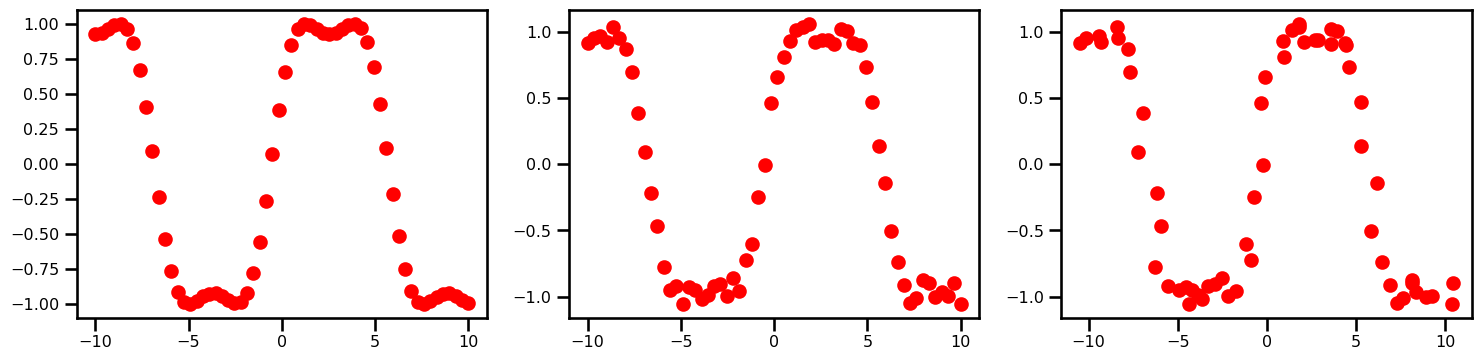

In [32]:
import jax
import jax.random as jr
import jax.numpy as jnp

key = jax.random.PRNGKey(123)
y_noise = 0.05
x_noise = 0.3

f = lambda x: jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + 0.5 * x))
ntrain = 60

X = jnp.linspace(-10, 10, ntrain).reshape(-1, 1)

key, y_rng = jax.random.split(key, 2)
y = f(X)

# Noisy Signal

key, x_rng = jax.random.split(key, 2)

X_noise = X + x_noise * jax.random.normal(x_rng, shape=X.shape)
y_noise = f(X) + y_noise * jax.random.normal(y_rng, shape=X.shape)

# sort inputs
idx_sorted = jnp.argsort(X_noise, axis=0).squeeze()

X_noise = X_noise[(idx_sorted,)]
y_noise = y_noise[(idx_sorted,)]
X = X[(idx_sorted,)]
y = y[(idx_sorted,)]

ntest = 100


Xtest = jnp.linspace(-10.1, 10.1, ntest)[:, None]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
ax[0].scatter(X, y, color="red")
ax[1].scatter(X, y_noise, color="red")
ax[2].scatter(X_noise, y_noise, color="red")
plt.show()

## GP Model

In [3]:
from gpjax.gps import Prior
from gpjax.mean_functions import Zero
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian
from gpjax.types import Dataset
from gpjax.parameters import initialise

In [4]:
# GP Prior
mean_function = Zero()
kernel = RBF()
prior = Prior(mean_function=mean_function, kernel=kernel)

# GP Likelihood
lik = Gaussian()

# GP Posterior
posterior = prior * lik

# initialize training dataset
training_ds = Dataset(X=X, y=y_noise)

### Training

In [5]:
# PARAMETERS
from gpjax.parameters import initialise
import numpyro.distributions as dist
from gpjax.interfaces.numpyro import numpyro_dict_params, add_constraints


# initialize parameters
params = initialise(posterior)


hyperpriors = {
    "lengthscale": 1.0,
    "variance": 1.0,
    "obs_noise": 0.01,
}


# convert to numpyro-style params
numpyro_params = numpyro_dict_params(hyperpriors)

# convert to numpyro-style params
numpyro_params = add_constraints(numpyro_params, dist.constraints.softplus_positive)

# INFERENCE
from numpyro.infer.autoguide import AutoDelta
from gpjax.interfaces.numpyro import numpyro_marginal_ll, numpyro_dict_params


# initialize numpyro-style GP model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# approximate posterior
guide = AutoDelta(npy_model)

# TRAINING
import numpyro
from numpyro.infer import SVI, Trace_ELBO

# reproducibility
key, opt_key = jr.split(key, 2)
n_iterations = 2_000
lr = 0.1

# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=lr)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(opt_key, n_iterations, training_ds)

# Learned Params
learned_params = svi_results.params

100%|██████████| 2000/2000 [00:04<00:00, 419.95it/s, init loss: -1054.1302, avg. loss [1901-2000]: -2595.9200]


In [29]:
from gpjax import mean, variance

meanf = mean(posterior, learned_params, training_ds)
covarf = variance(posterior, learned_params, training_ds)
varf = lambda x: jnp.atleast_1d(jnp.diag(covarf(x)))


mu = meanf(Xtest).squeeze()
var = varf(Xtest).squeeze()

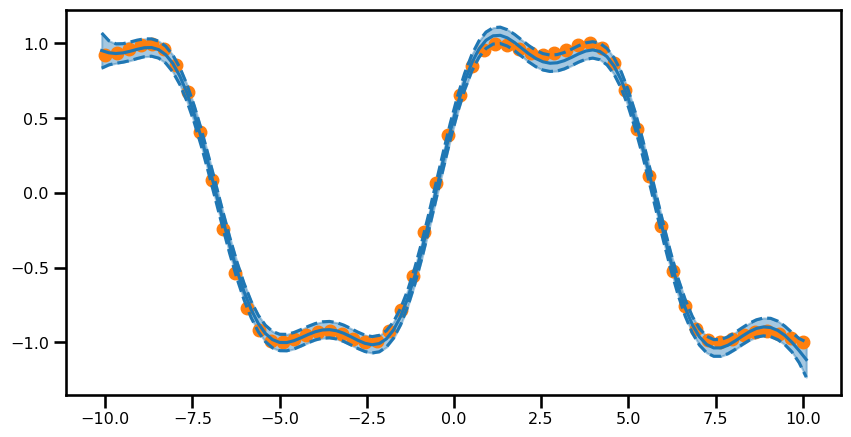

In [30]:
from jaxkern.viz import plot_1D_GP

plot_1D_gp_clean = jax.partial(plot_1D_GP, X=X, y=y, Xtest=Xtest)

fig, ax = plot_1D_gp_clean(ytest=mu, y_mu=mu, y_var=var)

## Test Data

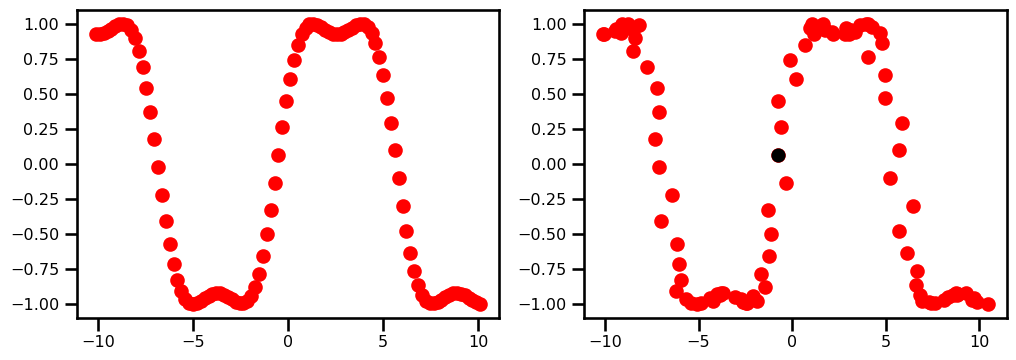

In [46]:
input_cov = jnp.array([0.1]).reshape(-1, 1) ** 2


Xtest = jnp.linspace(-10.1, 10.1, ntest)[:, None]
ytest = f(Xtest)

demo_sample_idx = 47

key, xt_rng = jax.random.split(key, 2)

Xtest_noisy = Xtest + x_noise * jax.random.normal(xt_rng, shape=Xtest.shape)


idx_sorted = jnp.argsort(Xtest_noisy, axis=0)

# Xtest = Xtest[(idx_sorted,)]
Xtest_noisy = Xtest_noisy[(idx_sorted,)][..., 0]
ytest_noisy = ytest[(idx_sorted,)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[1].scatter(Xtest_noisy, ytest_noisy, color="red")
ax[0].scatter(Xtest, ytest, color="red")
ax[1].scatter(
    Xtest_noisy[demo_sample_idx],
    ytest_noisy[demo_sample_idx],
    marker=".",
    s=300,
    color="black",
)
plt.show()

In [10]:
# # initialize parameters
# params = initialise(posterior)

# params = {"obs_noise": 0.00285, "lengthscale": 1.735, "variance": 0.6563}

## Predictions

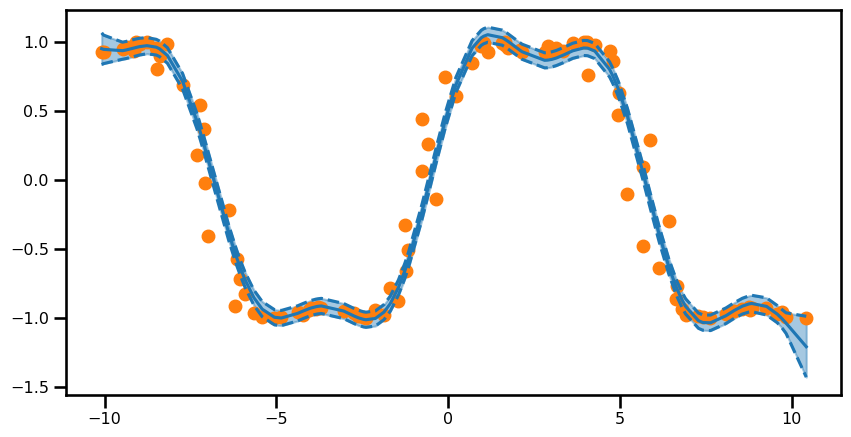

In [11]:
plot_1D_gp_noisy = jax.partial(
    plot_1D_GP, X=Xtest_noisy, y=ytest_noisy, Xtest=Xtest_noisy
)


mu = meanf(Xtest_noisy).squeeze()
var = varf(Xtest_noisy).squeeze()


# fig, ax = plot_1D_GP_noisy(Xtest_noisy, mu, var)
fig, ax = plot_1D_gp_noisy(ytest=mu, y_mu=mu, y_var=var)

## Moment Matching (MC)

In [38]:
from jaxkern.gp.uncertain.mcmc import MCMomentTransform
from typing import Callable, Dict
import chex
from jaxkern.kernels.expectations import e_Mx, e_Kx, e_Kxy, Psi1

mm_transform = MCMomentTransform(n_features=1, n_samples=1_000, seed=123)

In [33]:
# initialize function
mf = e_Mx(meanf, mm_transform,)


mf = jax.jit(jax.vmap(mf, in_axes=(0, None)))

In [34]:
y_mu = mf(Xtest_noisy.block_until_ready(), input_cov.block_until_ready())

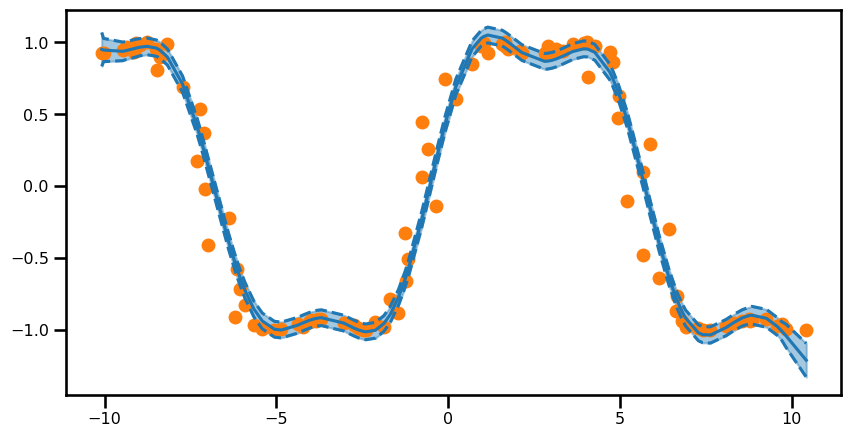

In [35]:
fig, ax = plot_1D_gp_noisy(ytest=y_mu, y_mu=y_mu, y_var=var.squeeze())

In [62]:
from jaxkern.kernels.expectations import e_Mx, e_Kx, e_Kxy, Psi1
from gpjax.kernels import gram
from gpjax.utils import I
from jax.scipy.linalg import cho_factor, cho_solve, cholesky, solve_triangular

psi1 = Psi1(posterior.prior.kernel, params, mm_transform=mm_transform, Y=training_ds.X)


sigma = params["obs_noise"]
n_train = training_ds.n
Kff = gram(posterior.prior.kernel, training_ds.X, params)
L = cholesky(Kff + I(n_train) * sigma, lower=True)
prior_mean = posterior.prior.mean_function(X)
prior_distance = y - prior_mean
weights = cho_solve((L, True), prior_distance)


def mf(X, X_cov):

    K = psi1(X, X_cov)[..., 0]

    print(K.shape, weights.shape)

    y_mu = jnp.sum(K @ weights)
    print(y_mu.shape)

    return y_mu


y_mu_ = mf(Xtest_noisy[0], input_cov)
y_mu_.shape

(60,) (60, 1)
()


()

In [63]:
y_mu_ = jax.vmap(mf, (0, None))(Xtest_noisy, input_cov)
y_mu_.shape

(60,) (60, 1)
()


(100,)

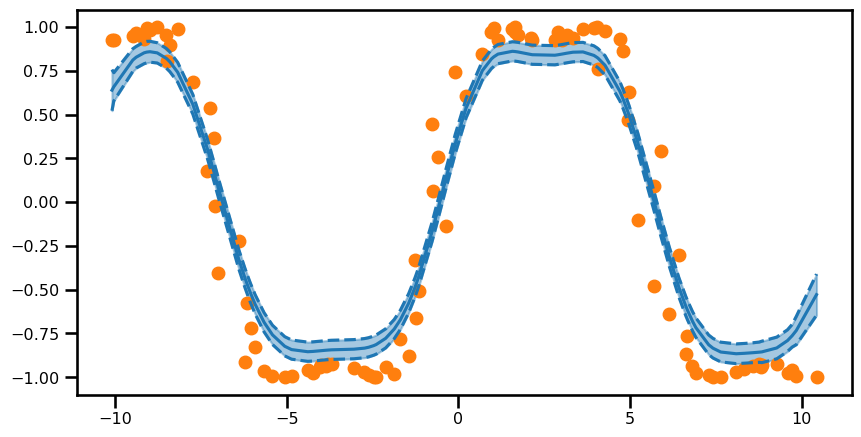

In [64]:
fig, ax = plot_1D_gp_noisy(ytest=y_mu_, y_mu=y_mu_, y_var=var.squeeze())

In [44]:
plt.plot(Xtest_noisy, y_mu)
plt.show()

In [36]:
from jaxkern.gp.uncertain.predict import moment_matching_predict_f

n_features = 1
mc_samples = 100
covariance = False
# input_cov = jnp.array([0.1]).reshape(-1, 1)

mm_transform = MCMomentTransform(n_features=n_features, n_samples=mc_samples, seed=42)

mm_predict_f = moment_matching_predict_f(
    posterior, params, training_ds, mm_transform, obs_noise=False
)

mm_mean_f = jax.vmap(mm_predict_f, in_axes=(0, None))

mu, var_ = mm_mean_f(Xtest_noisy, input_cov)

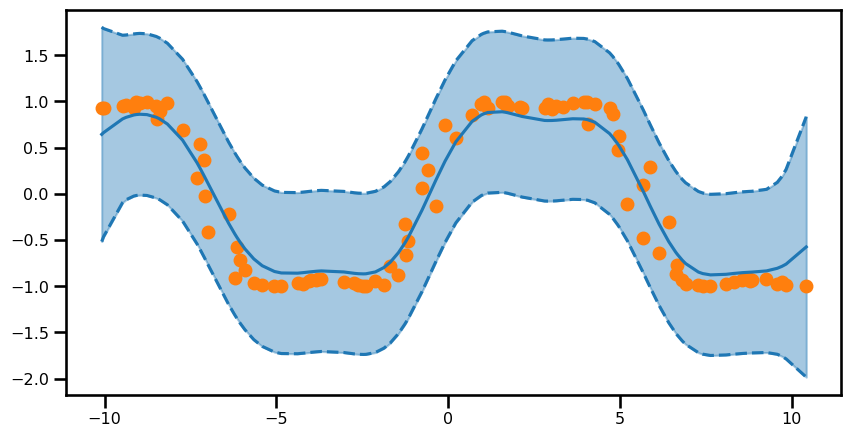

In [37]:
fig, ax = plot_1D_gp_noisy(ytest=mu, y_mu=mu, y_var=var_.squeeze())

In [8]:
from gpjax import mean, variance

meanf = mean(posterior, params, training_ds)
covarf = variance(posterior, params, training_ds)
varf = lambda x: jnp.atleast_1d(jnp.diag(covarf(x)))


mu = meanf(Xtest_noisy).squeeze()
var = varf(Xtest_noisy).squeeze()
y_std = 1.96 * jnp.sqrt(var)

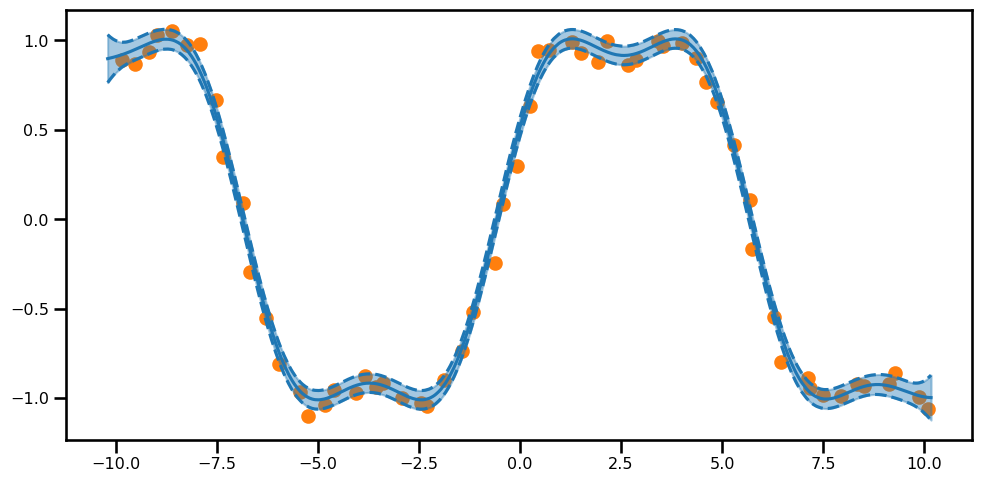

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(X_noise.squeeze(), y_noise.squeeze(), marker="o", color="tab:orange")
ax.plot(Xtest_noisy, mu.squeeze(), linestyle="-", color="tab:blue")
ax.fill_between(
    Xtest_noisy.ravel(),
    mu.ravel() - y_std,
    mu.ravel() + y_std,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(Xtest_noisy, mu.squeeze() - y_std.squeeze(), linestyle="--", color="tab:blue")
ax.plot(Xtest_noisy, mu.squeeze() + y_std.squeeze(), linestyle="--", color="tab:blue")
plt.tight_layout()
plt.show()

In [9]:
n_features = 1


xtest_sample = Xtest[0]
xtrain_sample = X[0]

xtest_sample = jnp.atleast_1d(xtest_sample)
xtrain_sample = jnp.atleast_1d(xtrain_sample)

### Moment Transform

In [11]:
from jaxkern.gp.uncertain.mcmc import MCMomentTransform
from jaxkern.gp.uncertain.unscented import UnscentedTransform, SphericalRadialTransform
from jaxkern.gp.uncertain.quadrature import GaussHermite

mm_transform = MCMomentTransform(n_features=1, n_samples=1_000, seed=123)
# mm_transform = UnscentedTransform(n_features=1, alpha=1.0, beta=2.0, kappa=None)
# mm_transform = GaussHermite(n_features=1, degree=20)
# mm_transform = SphericalRadialTransform(n_features=1)

## Mean Expectations

In [11]:
from typing import Callable, Dict
import chex
from jaxkern.kernels.expectations import e_Mx, e_Kx, e_Kxy

In [12]:
# initialize function
f = e_Mx(meanf, mm_transform,)

y_mu = f(xtest_sample, X_cov)


chex.assert_shape(y_mu, (n_features,))

In [13]:
f = e_Mx(meanf, mm_transform,)


f = jax.jit(jax.vmap(f, in_axes=(0, None)))

In [14]:
%%time

y_mu = f( Xtest.block_until_ready(), X_cov.block_until_ready())

chex.assert_shape(y_mu, (ntest, n_features,))

CPU times: user 62.7 ms, sys: 2.78 ms, total: 65.5 ms
Wall time: 61.3 ms


In [15]:
plt.plot(Xtest, y_mu)
plt.plot(Xtest, mu)

In [16]:
# chex.assert_tree_all_close(mu.squeeze(), y_mu.squeeze())

## Mean Prediction


$$
\tilde{\boldsymbol{\mu}}_{MMGP}(\mathbf{x_*}) = \Psi_1^\top\alpha 
$$

In [17]:
from jaxkern.gp.uncertain.predict import moment_matching_mean

In [18]:
mm_mean_f = moment_matching_mean(posterior, params, training_ds, mm_transform)

y_mm_mu = mm_mean_f(xtest_sample, X_cov)
chex.assert_equal_shape([y_mm_mu, xtest_sample])

In [19]:
mm_mean_f = moment_matching_mean(posterior, params, training_ds, mm_transform)

mm_mean_f = jax.jit(jax.vmap(mm_mean_f, in_axes=(0, None)))

In [20]:
%%time

y_mm_mu = mm_mean_f(Xtest, X_cov)

CPU times: user 214 ms, sys: 1.89 s, total: 2.11 s
Wall time: 94.1 ms


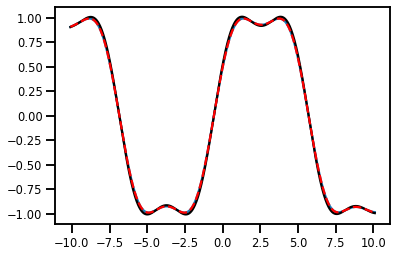

In [21]:
%matplotlib inline

plt.plot(Xtest, y_mu)
plt.plot(Xtest, mu, color="black")
plt.plot(Xtest, y_mm_mu, linestyle="--", color="red")

## Predictive Variance Function


$$
\tilde{\mathbf{\Sigma}}^2_{MMGP}(\mathbf{x}_*)
=
\psi_0 - \text{Tr}\left( \left(\mathbf{K}_{GP}^{-1}  - \alpha\alpha^\top\right) \Psi_2\right) - \text{Tr}\left( \Psi_1\Psi_1^\top\alpha\alpha^\top \right),
$$

In [22]:
type(mm_transform)

jaxkern.gp.uncertain.unscented.UnscentedTransform

In [23]:
# from gpjax.gps import ConjugatePosterior
# from chex import dataclass, Array
# from gpjax.kernels import gram
# from gpjax.utils import I
# from jax.scipy.linalg import cho_factor, cho_solve, cholesky, solve_triangular
# from jaxkern.kernels.expectations import Psi2, Psi0, Psi1
# from jaxkern.gp.uncertain.moment import MomentTransform


# def moment_matching_variance(
#     gp: ConjugatePosterior,
#     param: dict,
#     training: Dataset,
#     mm_transform: dataclass,
#     obs_noise: bool = True,
# ) -> Callable:
#     X, y = training.X, training.y
#     sigma = param["obs_noise"]
#     n_train = training.n
#     Kff = gram(gp.prior.kernel, X, param)
#     L = cholesky(Kff + I(n_train) * sigma, lower=True)
#     L_inv = solve_triangular(L.T, jnp.eye(L.shape[0]))
#     K_inv = L_inv.dot(L_inv.T)

#     prior_mean = gp.prior.mean_function(X)
#     prior_distance = y - prior_mean
#     weights = cho_solve((L, True), prior_distance)

#     if obs_noise:
#         noise_constant = sigma
#     else:
#         noise_constant = 1.0

#     # ======================
#     # Kernel Expectations
#     # ======================
#     # Psi0 - E_x[k(x,x)]
#     psi0 = e_Kx(gp.prior.kernel, param, mm_transform=mm_transform)

#     # Psi1 - E_x[k(x,y)]
#     psi1 = Psi1(gp.prior.kernel, param, mm_transform=mm_transform, Y=X)

#     # Psi2 - E_x[k(x,y)k(x,z)]
#     psi2 = Psi2(gp.prior.kernel, param, mm_transform=mm_transform, Y=X, Z=X,)

#     def varf(test_inputs: Array, test_cov: Array) -> Array:

#         # term 1
#         t1 = psi0(test_inputs, test_cov)
#         #         print(t1.shape)

#         # term 2
#         t2 = K_inv - weights @ weights.T
#         #         print(t2.shape)
#         t2 = t2 @ psi2(test_inputs, test_cov)
#         #         print(t2.shape)
#         t2 = jnp.trace(t2)

#         # Term 3
#         t3 = psi1(test_inputs, test_cov)
#         #         print(t3.shape)
#         t3 = t3 @ t3.T @ weights @ weights.T
#         #         print(t3.shape)
#         t3 = jnp.trace(t3)
#         #         print(t3.shape)

#         t = t1.squeeze() - t2.squeeze() - t3.squeeze() + noise_constant

#         t = jnp.atleast_1d(t)

#         return t

#     return varf

In [24]:
from jaxkern.gp.uncertain.predict import moment_matching_variance

In [25]:
mm_var_f = moment_matching_variance(posterior, params, training_ds, mm_transform)

y_mm_var = mm_var_f(xtest_sample, X_cov)
chex.assert_equal_shape([y_mm_var, xtest_sample])

In [26]:
mm_mean_f = moment_matching_mean(posterior, params, training_ds, mm_transform)
mm_var_f = moment_matching_variance(posterior, params, training_ds, mm_transform)

mm_mean_f = jax.jit(jax.vmap(mm_mean_f, in_axes=(0, None)))
mm_var_f = jax.jit(jax.vmap(mm_var_f, in_axes=(0, None)))

In [27]:
%%time

y_mm_mu = mm_mean_f(Xtest, X_cov).squeeze()
y_mm_var = mm_var_f(Xtest, X_cov).squeeze()

y_mm_std = 1.96 * jnp.sqrt(y_mm_var).squeeze()

CPU times: user 516 ms, sys: 1.91 s, total: 2.42 s
Wall time: 392 ms


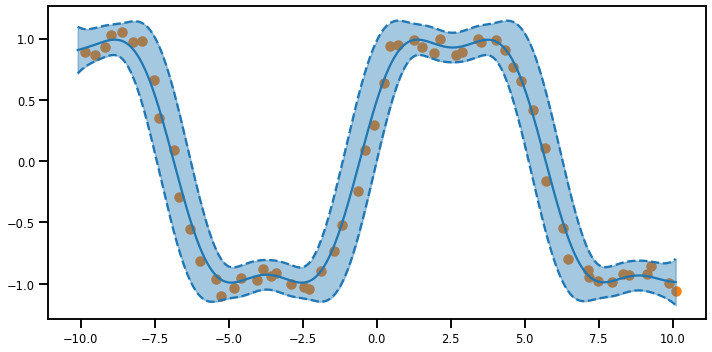

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(X_noise.squeeze(), y_noise.squeeze(), marker="o", color="tab:orange")
ax.plot(Xtest, y_mm_mu.squeeze() - y_mm_std.squeeze(), linestyle="--", color="tab:blue")
ax.fill_between(
    Xtest.ravel(),
    y_mm_mu.ravel() - y_mm_std,
    y_mm_mu.ravel() + y_mm_std,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(Xtest, y_mm_mu.squeeze())
ax.plot(Xtest, y_mm_mu.squeeze() + y_mm_std.squeeze(), linestyle="--", color="tab:blue")
plt.tight_layout()
plt.show()

## Moment Matching

In [12]:
from jaxkern.gp.uncertain.predict import moment_matching_predict_f

mm_predict_f = moment_matching_predict_f(posterior, params, training_ds, mm_transform)

mm_mean_f = jax.jit(jax.vmap(mm_predict_f, in_axes=(0, None)))

In [ ]:
X_cov

In [13]:
y_mm_mu, y_mm_var = mm_mean_f(Xtest, X_cov)

y_mm_std = 1.96 * jnp.sqrt(y_mm_var).squeeze()

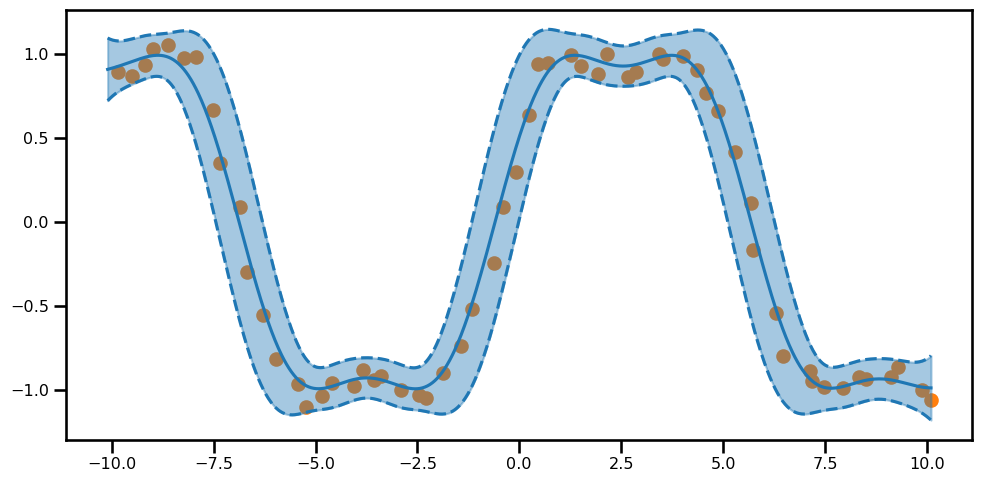

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(X_noise.squeeze(), y_noise.squeeze(), marker="o", color="tab:orange")
ax.plot(Xtest, y_mm_mu.squeeze() - y_mm_std.squeeze(), linestyle="--", color="tab:blue")
ax.fill_between(
    Xtest.ravel(),
    y_mm_mu.ravel() - y_mm_std,
    y_mm_mu.ravel() + y_mm_std,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(Xtest, y_mm_mu.squeeze())
ax.plot(Xtest, y_mm_mu.squeeze() + y_mm_std.squeeze(), linestyle="--", color="tab:blue")
plt.tight_layout()
plt.show()